In [1]:
from datascience import *
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

## Review

In [2]:
def standard_units(arr):
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

def slope(t, x, y):
    r = correlation(t, x, y)
    y_sd = np.std(t.column(y))
    x_sd = np.std(t.column(x))
    return r * y_sd / x_sd

def intercept(t, x, y):
    x_mean = np.mean(t.column(x))
    y_mean = np.mean(t.column(y))
    return y_mean - slope(t, x, y)*x_mean

def fitted_values(t, x, y):
    """Return an array of the regression estimates at all the x values"""
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a*t.column(x) + b

def residuals(t, x, y):
    """Return an array of all the residuals"""
    predictions = fitted_values(t, x, y)
    return t.column(y) - predictions

In [3]:
births = Table.read_table('baby.csv')
births.sample(3).show()

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
96,265,28,59,135,True
106,276,30,66,130,False
117,270,23,58,115,False


We will do a little bit of exploration, like always.

In [4]:
births = Table.read_table('baby.csv')
births.show(3)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True


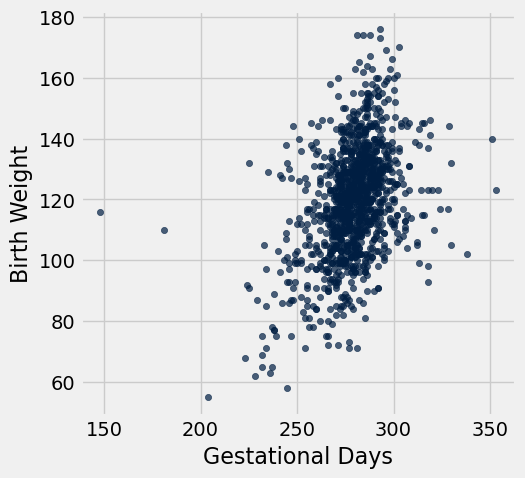

In [5]:
births.scatter('Gestational Days', 'Birth Weight')
plots.show()

In [6]:
correlation(births, 'Gestational Days', 'Birth Weight')

0.40754279338885108

Preterm and postterm pregnancy cutoffs, according to the CDC.

In [7]:
# Preterm and postterm pregnancy cutoffs, according to the CDC
make_array(37 * 7, 42 * 7)

array([259, 294])

In [8]:
births = births.where('Gestational Days', are.between(225, 325))

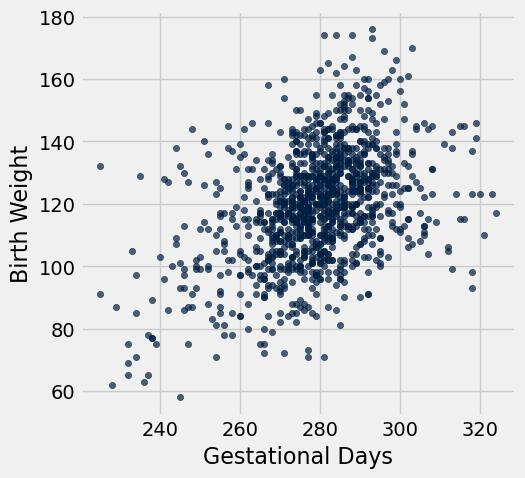

In [11]:
births.scatter('Gestational Days', 'Birth Weight')
plots.show()

In [12]:
correlation(births, 'Gestational Days', 'Birth Weight')

0.42295118452423991

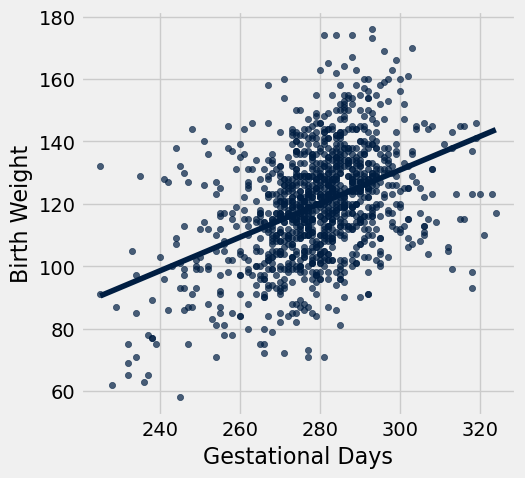

In [13]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.show()

## New material

### A model consists of signal and noise

Ignore this code; it produces plots for demonstrating the regression model and has no conceptual value.

The points created will differ each time this piece of code is run!

In [14]:
def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    errors = np.random.normal(0, 6, sample_size)
    y = (true_slope * x + true_int) + errors
    sample = Table().with_columns('x', x, 'y', y)

    sample.scatter('x', 'y')
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title('True Line, and Points Created')

    sample.scatter('x', 'y')
    plots.title('What We Get to See')

    sample.scatter('x', 'y', fit_line=True)
    plots.title('Regression Line: Estimate of True Line')

    sample.scatter('x', 'y', fit_line=True)
    plots.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plots.title("Regression Line and True Line")

Sample size = 10

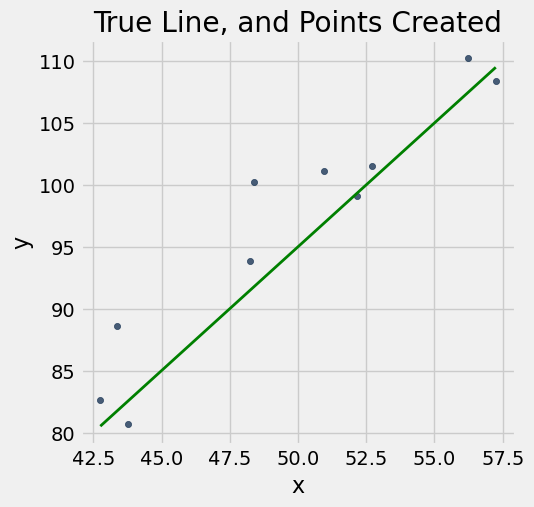

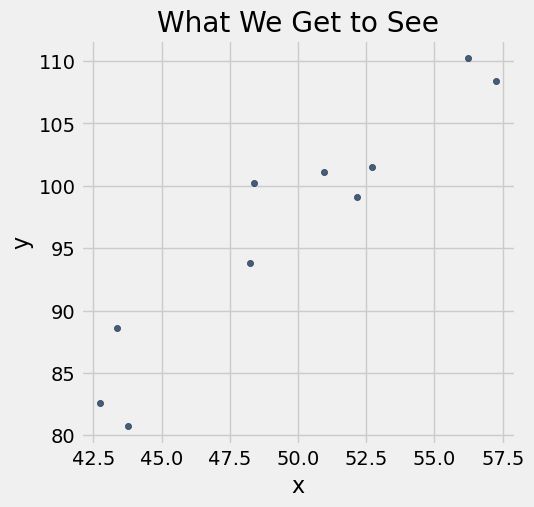

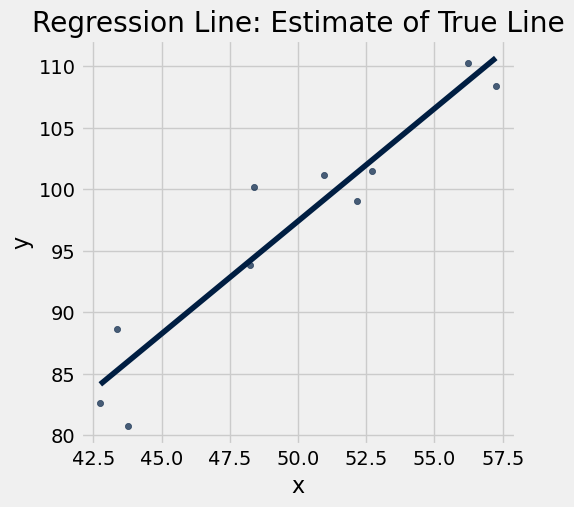

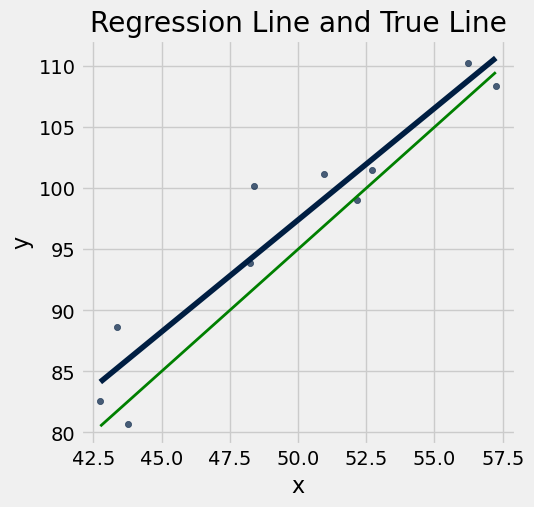

In [15]:
draw_and_compare(true_slope=2, true_int=-5, sample_size=10)
plots.show()

Sample size = 100

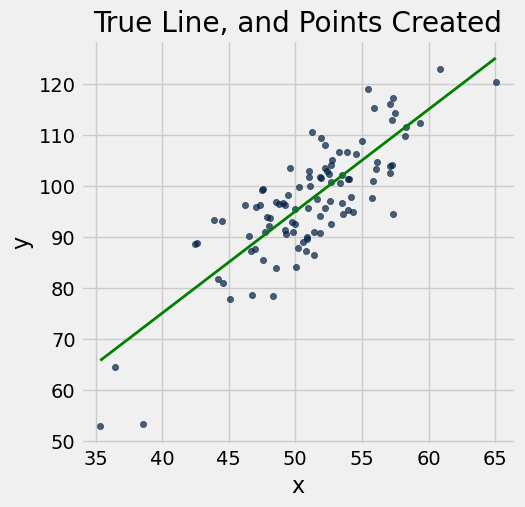

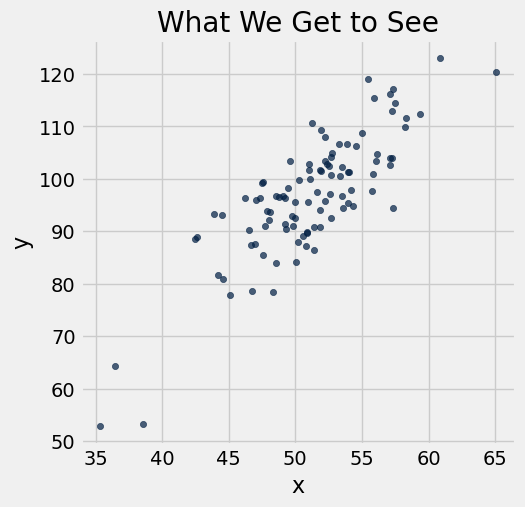

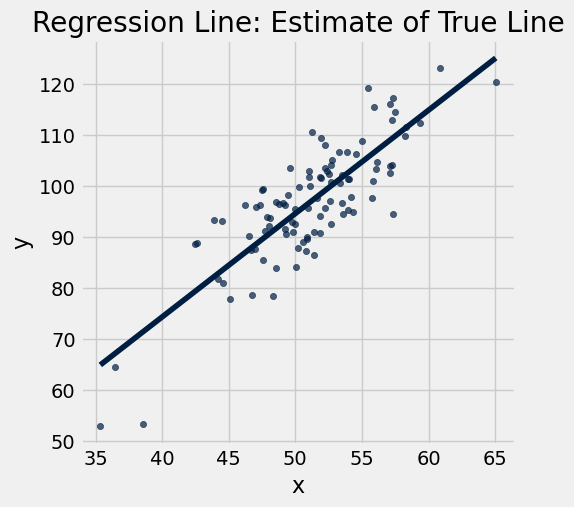

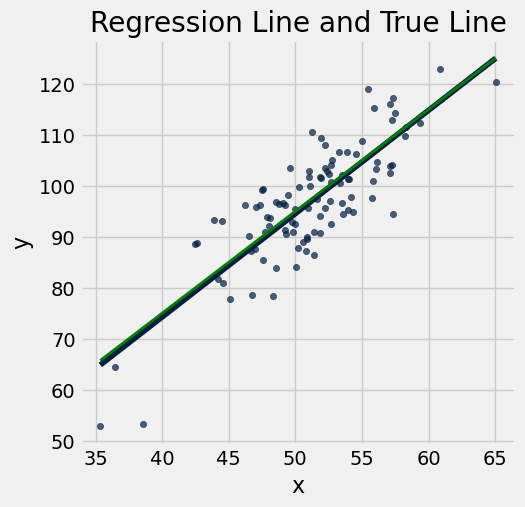

In [16]:
draw_and_compare(true_slope=2, true_int=-5, sample_size=100)
plots.show()

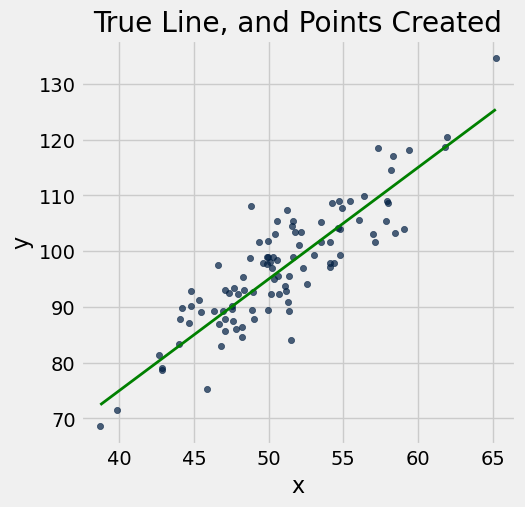

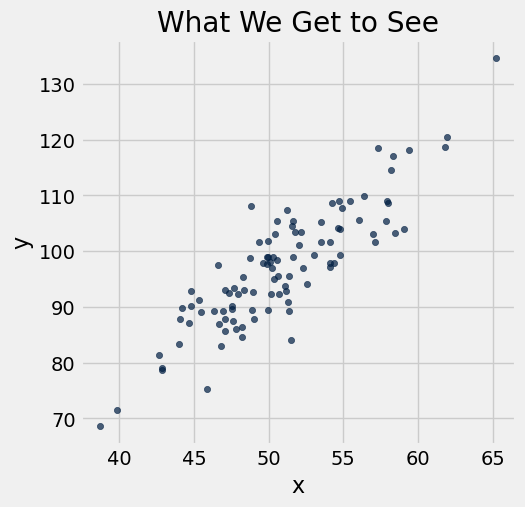

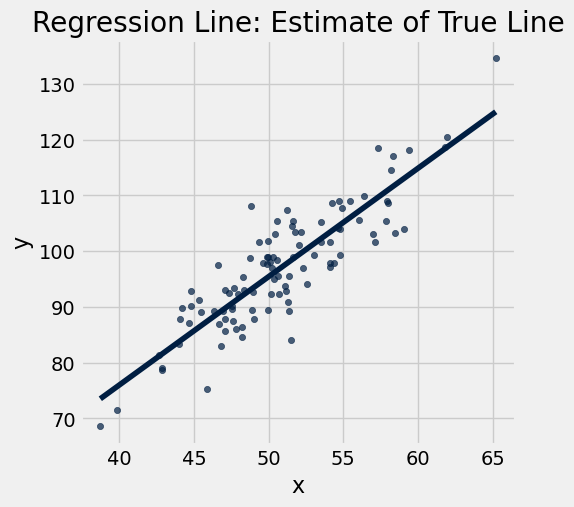

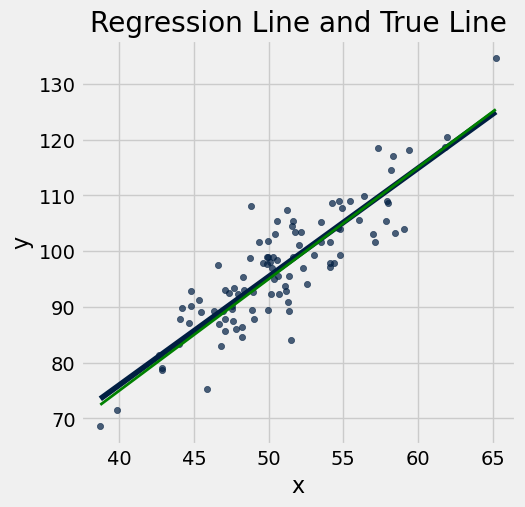

In [17]:
draw_and_compare(true_slope=2, true_int=-5, sample_size=100)
plots.show()

**STOP**

### Can we give an estimate for the **true** relationship between two numerical variables $x$ and $y$?

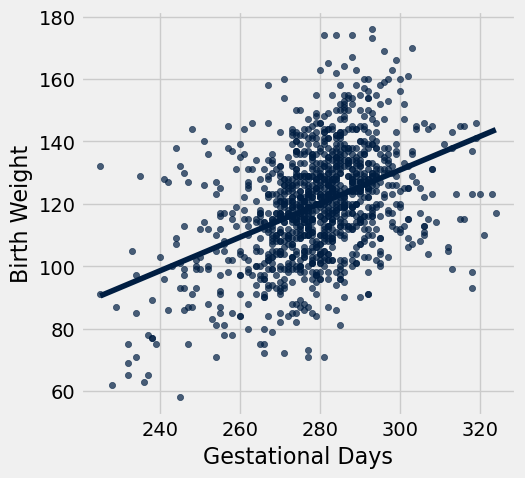

In [18]:
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.show()

In [19]:
slope(births, 'Gestational Days', 'Birth Weight')

0.53784536766790358

In [20]:
def bootstrap_slope_interval(t, x, y, repetitions=2500):
    """ 
    Makes a 95% confidence interval for the slope of the true line, 
    using linear regression on the data in t (column names x and y).
    Shows a histogram of the bootstrap samples and shows the interval
    in gold.
    """
    
    # Bootstrap the scatter, find the slope, collect
    slopes = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        bootstrap_slope = slope(bootstrap_sample, x, y)
        slopes = np.append(slopes, bootstrap_slope)
    
    # Find the endpoints of the 95% confidence interval for the true slope
    left = percentile(2.5, slopes)
    right = percentile(97.5, slopes)
    round_left = round(left, 3)
    round_right = round(right, 3)
    
    # Slope of the regression line from the original sample
    observed_slope = slope(t, x, y)
    
    # Display results (no need to follow this code)
    Table().with_column('Bootstrap Slopes', slopes).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8);
    print('Slope of regression line:', round(observed_slope, 3))
    print('Approximate 95%-confidence interval for the slope of the true line:')
    print(round_left, 'to', round_right)

Slope of regression line: 0.538
Approximate 95%-confidence interval for the slope of the true line:
0.46 to 0.616


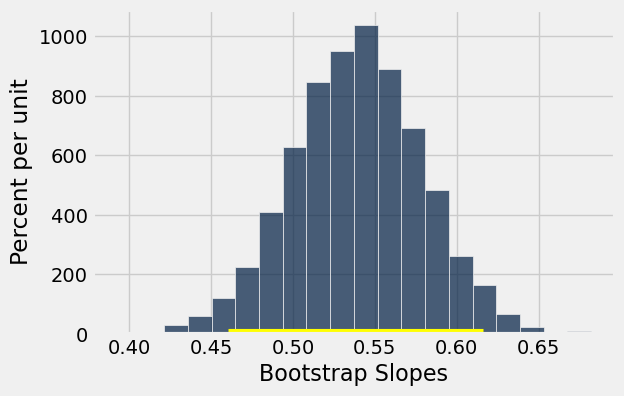

In [21]:
bootstrap_slope_interval(births, 'Gestational Days', 'Birth Weight')
plots.show()

**STOP**

### What if the true line is actually *flat*?! 

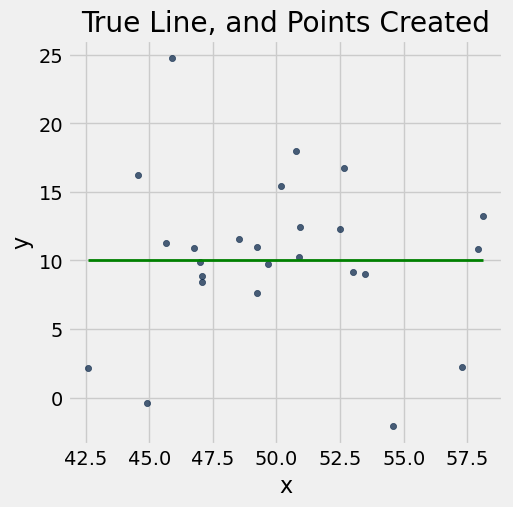

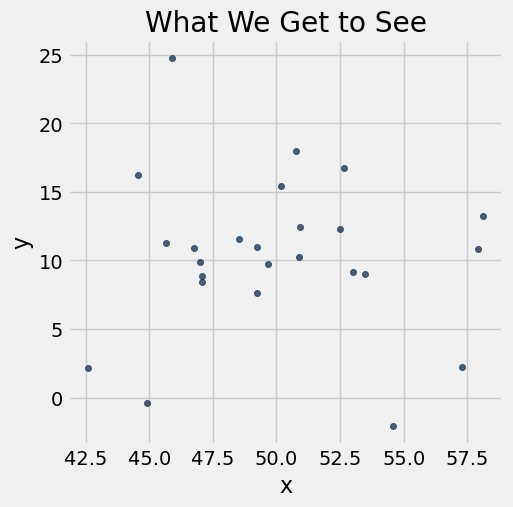

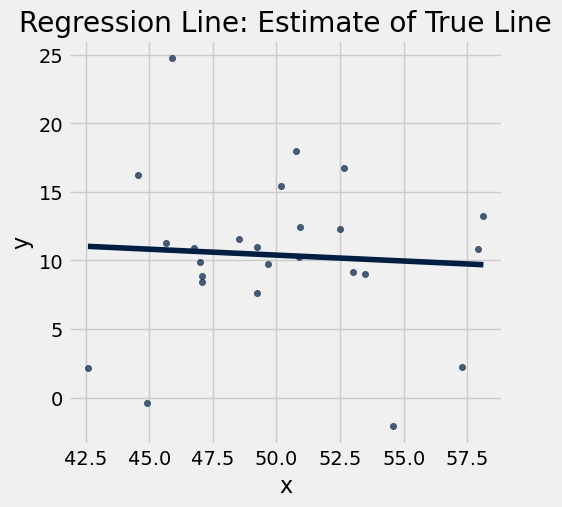

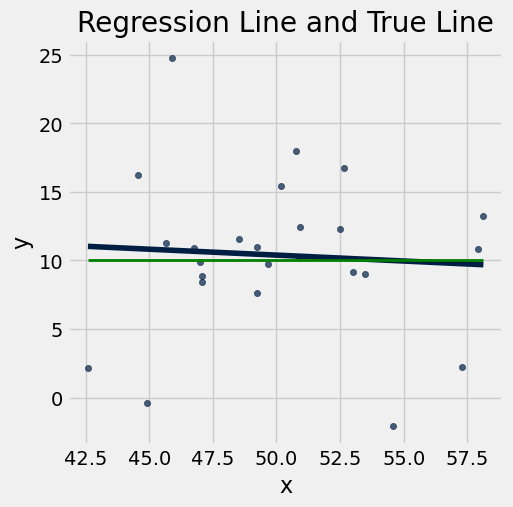

In [22]:
draw_and_compare(true_slope=0, true_int=10, sample_size=25)
plots.show()

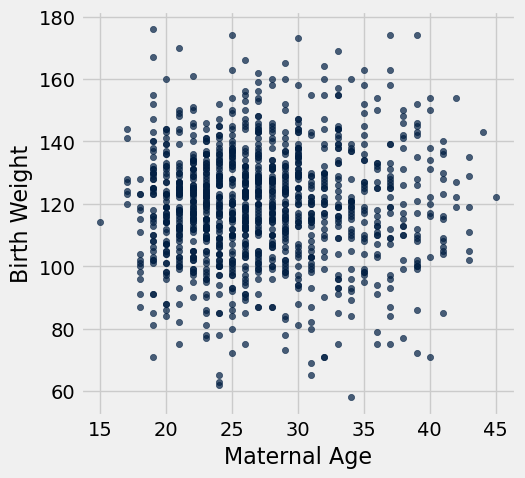

In [23]:
births.scatter('Maternal Age', 'Birth Weight')
plots.show()

In [24]:
slope(births, 'Maternal Age', 'Birth Weight')

0.095142237298344659

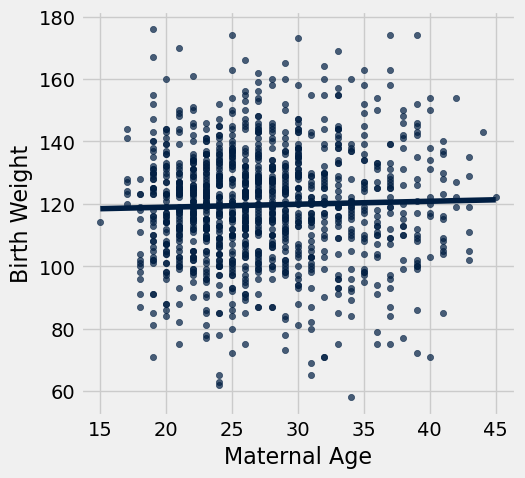

In [27]:
births.scatter('Maternal Age', 'Birth Weight', fit_line=True)
plots.show()

**Null:** Slope of true line is equal to 0.

**Alternative:** Slope of true line is not equal to 0.

Slope of regression line: 0.095
Approximate 95%-confidence interval for the slope of the true line:
-0.09 to 0.285


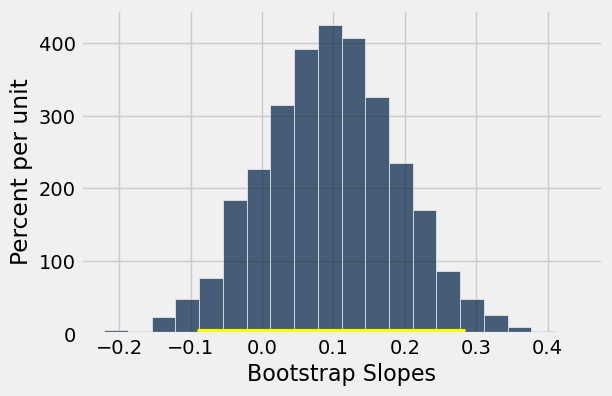

In [28]:
bootstrap_slope_interval(births, 'Maternal Age', 'Birth Weight')
plots.show()

**Discussion Question**

### Can we predict the response of a new individual who is **not** in our sample?

In [29]:
def prediction_at(t, x, y, x_value):
    '''
    t - table
    x - label of x column
    y - label of y column
    x_value - the x value for which we want to predict y
    '''
    return slope(t, x, y) * x_value + intercept(t, x, y)

In [30]:
prediction_at_300 = prediction_at(births, 'Gestational Days', 'Birth Weight', 300)
prediction_at_300

130.80951674248769

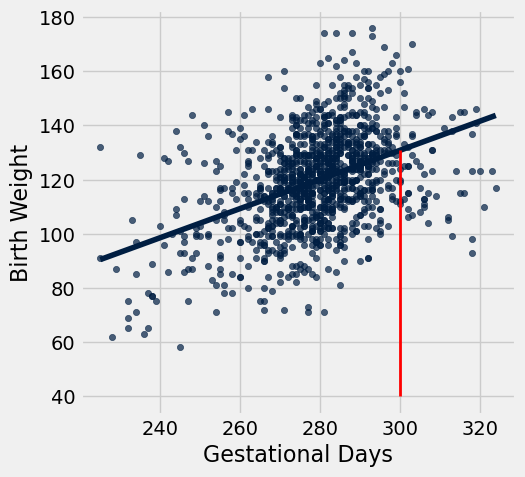

In [31]:
x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.plot([x, x], [40, prediction_at_300], color='red', lw=2)
plots.show();

- You don't need to understand the plotting code in this cell, but you should understand the figure that comes out.

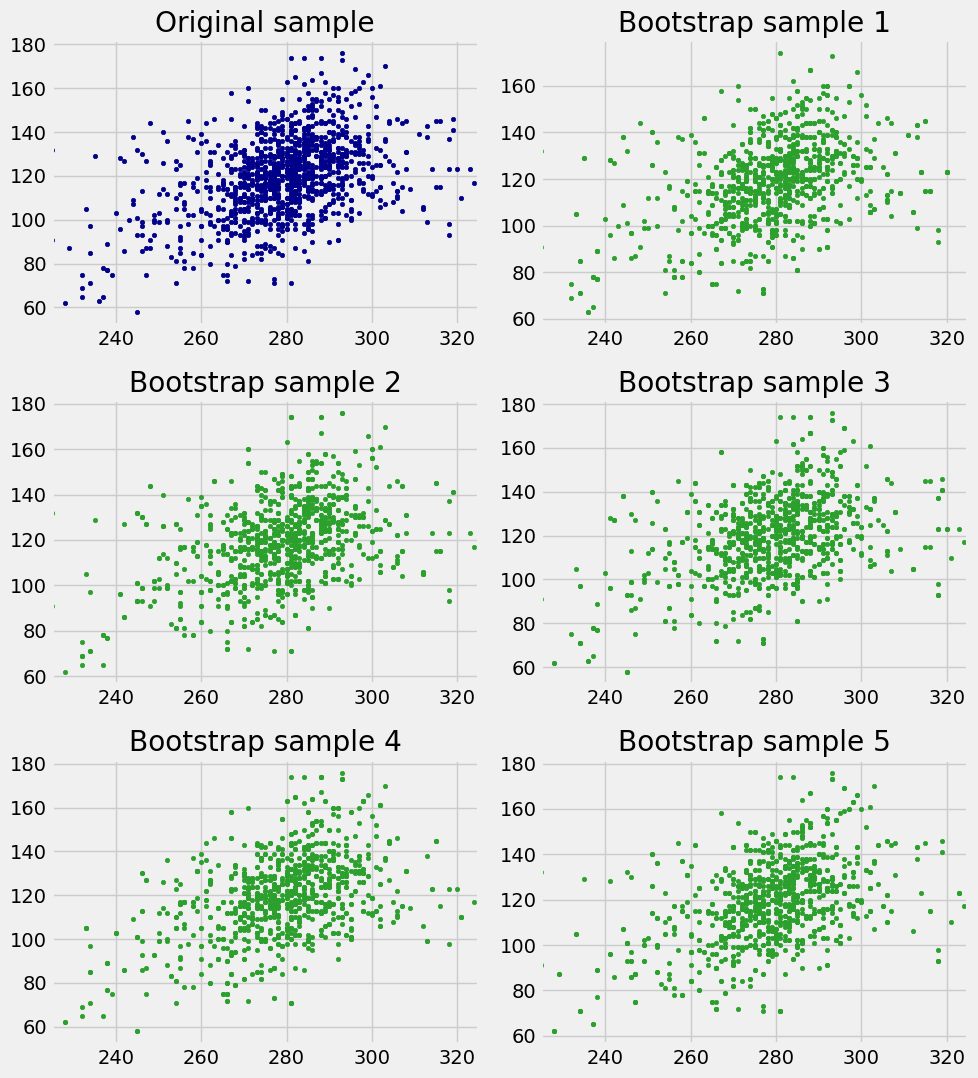

In [32]:
plots.figure(figsize=(10, 11))
plots.subplot(3, 2, 1)
plots.scatter(births[1], births[0], s=10, color='darkblue')
plots.xlim([225, 325])
plots.title('Original sample')

for i in np.arange(1, 6, 1):
    plots.subplot(3,2,i+1)
    resampled = births.sample()
    plots.scatter(resampled.column('Gestational Days'), resampled.column('Birth Weight'), s=10, color='tab:green')
    plots.xlim([225, 325])
    plots.title('Bootstrap sample '+str(i))
plots.tight_layout()
plots.show()

Predicted y from bootstrap sample was 131.476566229
Predicted y from bootstrap sample was 130.939579627
Predicted y from bootstrap sample was 131.736245629
Predicted y from bootstrap sample was 131.753747299


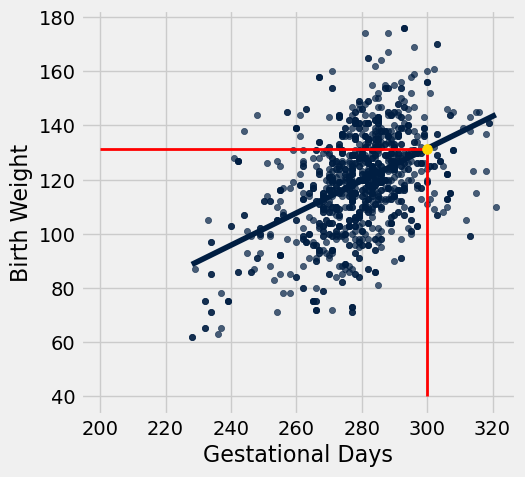

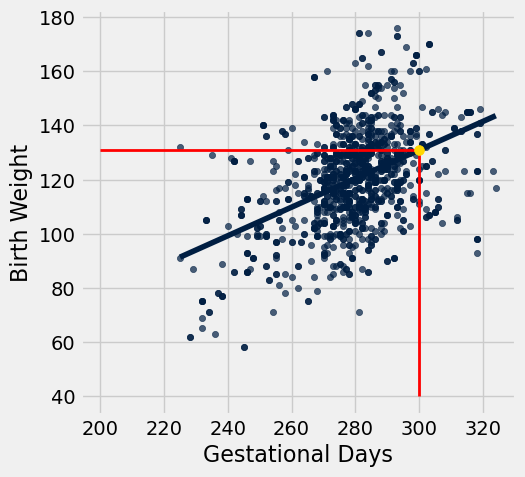

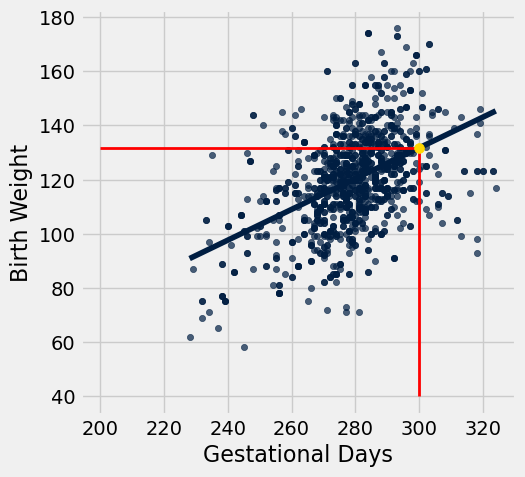

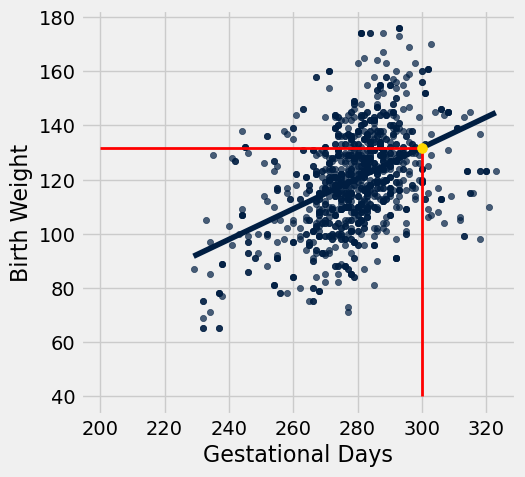

In [33]:
for i in np.arange(4):
    resample = births.sample()
    predicted_y = prediction_at(resample, 'Gestational Days', 'Birth Weight', 300)
    print('Predicted y from bootstrap sample was', predicted_y)
    resample.scatter('Gestational Days', 'Birth Weight', fit_line=True)
    plots.scatter(300, predicted_y, color='gold', s=50, zorder=3);
    plots.plot([x, x], [40, predicted_y], color='red', lw=2);
    plots.plot([200, x], [predicted_y, predicted_y], color='red', lw=2);
plots.show()

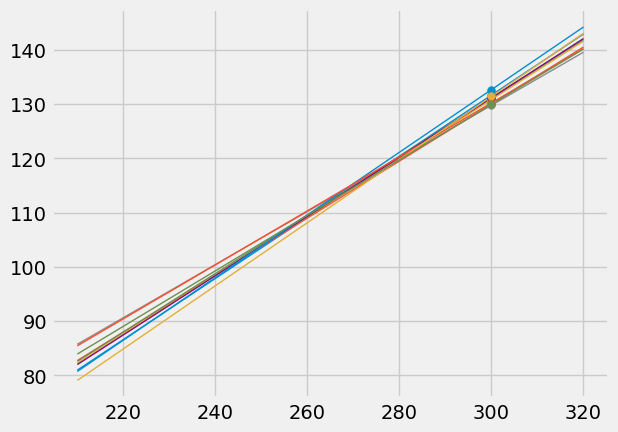

In [34]:
lines = Table(['slope','intercept', 'at 210', 'at 300', 'at 320'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 210 + b, a * 300 + b, a * 320 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([210, 320], [line.item('at 210'), line.item('at 320')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)
plots.show()

In [35]:
np.mean(births.column('Gestational Days')), np.mean(births.column('Birth Weight'))

(279.11015490533561, 119.57401032702238)

In [36]:
lines = Table(['slope','intercept', 'at 291', 'at 300', 'at 309'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 291 + b, a * 300 + b, a * 309 + b])
lines


slope,intercept,at 291,at 300,at 309
0.504603,-22.4317,124.408,128.949,133.491
0.523564,-26.5558,125.801,130.513,135.225
0.573072,-40.4858,126.278,131.436,136.594
0.480321,-14.596,125.177,129.5,133.823
0.521819,-26.1739,125.675,130.372,135.068
0.551717,-34.3538,126.196,131.161,136.127
0.50916,-23.0187,125.147,129.729,134.312
0.57358,-40.9308,125.981,131.143,136.306
0.530131,-27.922,126.346,131.117,135.888
0.507508,-21.6887,125.996,130.564,135.131


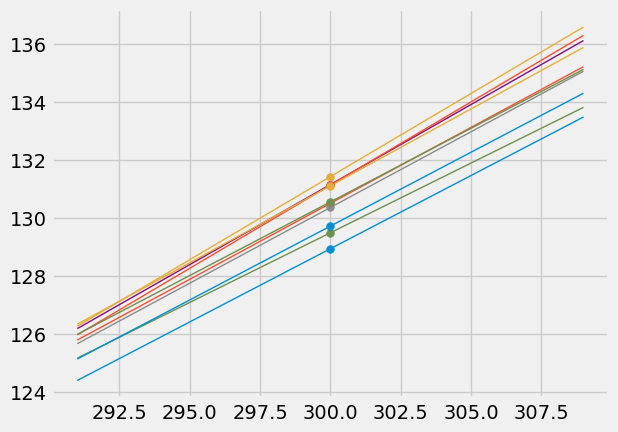

In [37]:
for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([291, 309], [line.item('at 291'), line.item('at 309')], lw=1)
    plots.scatter(300, line.item('at 300'), s=30, zorder=3)
plots.show()

______

In [38]:
def bootstrap_prediction(t, x, y, new_x, repetitions=2500):
    """ 
    Makes a 95% confidence interval for the height of the true line at new_x, 
    using linear regression on the data in t (column names x and y).
    Shows a histogram of the bootstrap samples and shows the interval
    in gold.
    """

    # Bootstrap the scatter, predict, collect
    predictions = make_array()
    for i in np.arange(repetitions):
        resample = t.sample()
        predicted_y = prediction_at(resample, x, y, new_x)
        predictions = np.append(predictions, predicted_y)

    # Find the ends of the approximate 95% prediction interval
    left = percentile(2.5, predictions)
    right = percentile(97.5, predictions)
    round_left = round(left, 3)
    round_right = round(right, 3)

    # Display results
    Table().with_column('Prediction', predictions).hist(bins=20)
    plots.xlabel('predictions at x='+str(new_x))
    plots.plot([left, right], [0, 0], color='yellow', lw=8);
    print('Approximate 95%-confidence interval for height of true line at x =', new_x)
    print(round_left, 'to', round_right, '( width =', round(right - left, 3), ')') 

**STOP**

### The prediction interval depends on the value of $x$

**Discussion Question**

Approximate 95%-confidence interval for height of true line at x = 300
128.909 to 132.704 ( width = 3.794 )


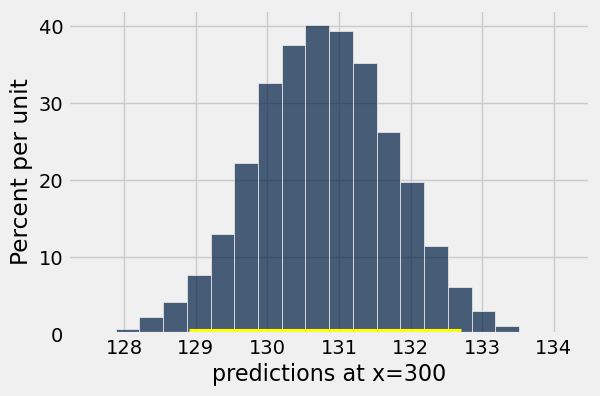

In [39]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 300)
plots.show()

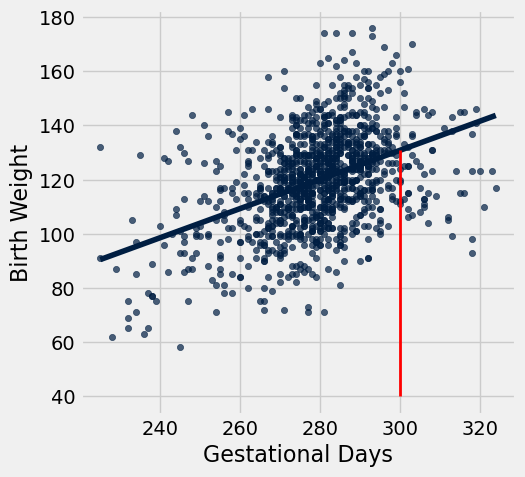

In [40]:
x = 300
births.scatter('Gestational Days', 'Birth Weight', fit_line=True)
plots.plot([x, x], [40, prediction_at_300], color='red', lw=2)
plots.show();

Approximate 95%-confidence interval for height of true line at x = 230
89.095 to 97.293 ( width = 8.198 )


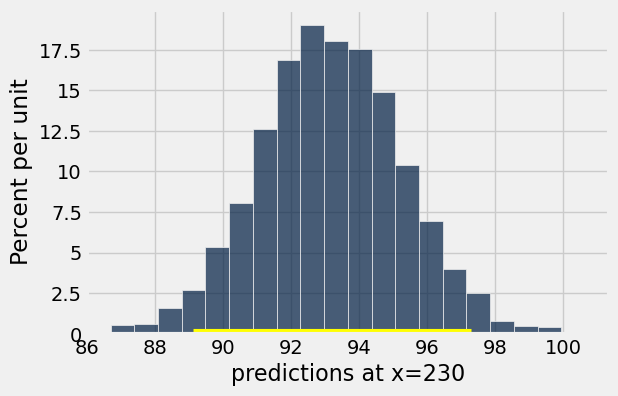

In [41]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 230)
plots.show()

Approximate 95%-confidence interval for height of true line at x = 280
119.099 to 120.964 ( width = 1.865 )


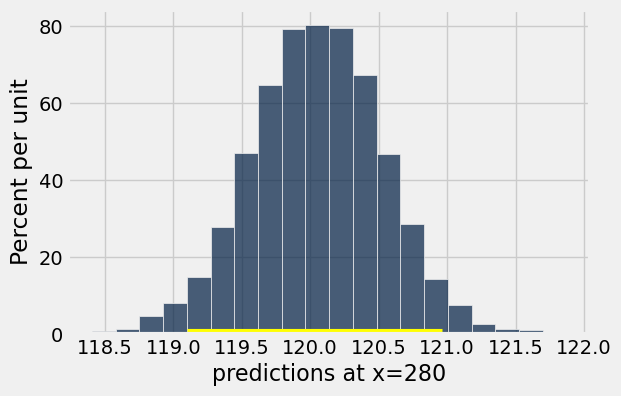

In [42]:
bootstrap_prediction(births, 'Gestational Days', 'Birth Weight', 280)
plots.show()

No need to follow the code in this cell; just understand the graph that comes out.

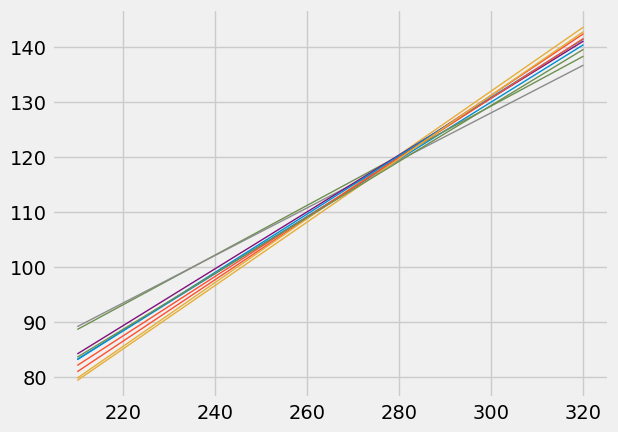

In [43]:
lines = Table(['slope','intercept', 'at 210', 'at 300', 'at 320'])

for i in range(10):
    resample = births.sample()
    a = slope(resample, 'Gestational Days', 'Birth Weight')
    b = intercept(resample, 'Gestational Days', 'Birth Weight')
    lines.append([a, b, a * 210 + b, a * 300 + b, a * 320 + b])

for i in np.arange(lines.num_rows):
    line = lines.row(i)
    plots.plot([210, 320], [line.item('at 210'), line.item('at 320')], lw=1)
plots.show()